# Introduzione

La piattaforma beehAIve è concepita con lo scopo di predire il **Colony Collapse Disorder (CCD)**, monitorando attentamente lo stato di salute delle arnie. Per raggiungere tale obiettivo, abbiamo la necessità di raccogliere dati rilevanti per il monitoraggio della salute delle arnie.

Attraverso i dati a nostra disposizione, svilupperemo un modello di Machine Learning che sia in grado di predire se una specifica arnia sia affetta o meno da CCD. Le feature utilizzate dal nostro modello riguardano in particolare tre caratteristiche, di estrema importanza per capire se l'arnia si trova effettivamente in uno stato di buona salute o meno:

- **Presenza della regina**: la presenza o l'assenza dell'ape regina all'interno dell'arnia è cruciale per comprendere lo stato di salute dell'arnia. L'assenza della regina, se non affrontata al più presto, ha una gravità tale da portare l'arnia al suo inevitabile peggioramento e abbandono;

- **Temperatura percepita interna all'arnia**: le api, per poter svolgere le loro mansioni in un ambiente abitabile, hanno bisogno di mantenere una determinata temperatura, più specificatamente uno specifico intervallo. Nel momento in cui la temperatura non viene mantenuta in tale intervallo, potrebbe significare che le api non sono in condizione di riscaldare o raffreddare l'arnia, il che potrebbe portare al peggioramento della loro salute e delle loro condizioni. Abbiamo deciso di utilizzare la temperatura percepita poiché mette direttamente in relazione la temperatura e l'umidità;

- **Differenza tra temperatura percepita esterna e interna all'arnia**: nel momento in cui la temperatura dell'arnia non si trova nell'intervallo prestabilito, è necessario studiare la differenza che c'è tra la temperatura esterna e la temperatura interna all'arnia. Questo perché, nel momento in cui la temperatura è troppo alta o troppo bassa e la differenza tra quella interna e quella esterna è minima, le api non stanno risolvendo in alcun modo tale problematica. Ciò potrebbe significare che le api non sono in condizioni tali da poter lavorare o, peggio ancora, hanno abbandonato l'arnia o sono morte per la maggior parte.

Per lo sviluppo del nostro modello avremo bisogno delle seguenti librerie:

In [ ]:
import pandas as pd
import numpy as np
import random  # Per lanciare la probabilità che l'arnia sia soggetta a CCD o meno
import matplotlib.pyplot as plt  # Per visualizzare i grafici
from sklearn.tree import DecisionTreeClassifier # Classificatore Decision Tree
from sklearn.ensemble import RandomForestClassifier # Classificatore Random Forest
from sklearn.naive_bayes import GaussianNB # Classificatore Naive Bayes
from sklearn.neighbors import KNeighborsClassifier # Classificatore K Neighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc # Metriche di valutazione
from sklearn.model_selection import StratifiedKFold, GridSearchCV # K Fold Validation e Grid Search
from matplotlib.colors import ListedColormap # Per cambiare i colori ai plot
import pickle # Per esportare il modello
from flask import Flask, jsonify, request # Per il deployment
import json # Per leggere l'input a Flask
from google.colab import data_table # Per una visualizzazione più pulita delle tabelle

<u>*Nota: Il codice fa ampio utilizzo di randomicità. Per evitare inconsistenze tra documentazione e Colab è consigliato caricare i dataset presenti nella repo di GitHub sotto src/ai/dataset e il modello da src/ai/development/Naive_Bayes.pickle. Se si desidera comunque eseguire il codice senza importare nulla, scommentare le righe segnate da #RANDOM, aspettandosi però risultati potenzialmente diversi (Anche se non sensibilmente).*</u>



# Data Understanding e Data Preparation

Prima di tutto, importiamo il **dataset** contenente le informazioni relative alle arnie:

In [ ]:
dataset = pd.read_csv("hive_dataset.csv")
dataset

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 14:52:28,36.42,30.29,1007.45,26.68,52,1013,8.75,...,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022-06-08 17:21:53,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1
3,1,5,2022-06-08 18:20:59,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,37.29,-121.95,2022-06-08--18-20-59_1.raw,0,0,8,1,0.750,1
4,1,5,2022-06-08 19:20:04,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,37.29,-121.95,2022-06-08--19-20-04_1.raw,0,0,8,1,0.792,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,2,1,2022-07-15 11:18:39,50.84,11.99,1010.21,23.58,55,1015,2.57,...,0,37.29,-121.95,2022-07-15--11-18-39_2.raw,1,2,10,5,0.458,3
1271,2,1,2022-07-15 12:25:14,49.58,11.60,1009.81,25.60,51,1015,4.12,...,0,37.29,-121.95,2022-07-15--12-25-14_2.raw,1,2,10,5,0.500,3
1272,2,1,2022-07-15 13:25:58,45.83,15.36,1009.80,26.49,49,1015,5.14,...,0,37.29,-121.95,2022-07-15--13-25-58_2.raw,1,2,10,5,0.542,3
1273,2,1,2022-07-15 14:24:58,35.82,23.48,1009.26,27.33,46,1014,4.63,...,0,37.29,-121.95,2022-07-15--14-24-58_2.raw,1,2,10,5,0.583,3


Il dataset sopra riportato è costituito da istanze i cui valori sono stati misurati da un sensore IoT interno a delle arnie, mentre la presenza dell'ape regina è stata inserita manualmente da degli apicoltori. Come possiamo notare, abbiamo un totale di **1275 campioni**.

Di seguito sono riportate tutte le **colonne** del nostro dataset:

In [ ]:
dataset.columns

Index(['device', 'hive number', 'date', 'hive temp', 'hive humidity',
       'hive pressure', 'weather temp', 'weather humidity', 'weather pressure',
       'wind speed', 'gust speed', 'weatherID', 'cloud coverage', 'rain',
       'lat', 'long', 'file name', 'queen presence', 'queen acceptance',
       'frames', 'target', 'time', 'queen status'],
      dtype='object')

Le colonne più interessanti alle finalità del nostro problema sono le seguenti: **hive temp**, **hive humidity**, **weather temp**, **weather humidity** e **queen presence**.

Dalla letteratura scientifica e potendo osservare il dataset, ci vengono incontro quelle che sono le prime e le più grandi problematiche che dobbiamo necessariamente affrontare:

- <u>**Non è presente la colonna relativa alle temperature percepite esterne ed interne all'arnia**</u>. A tal proposito, dovremo calcolarne noi stessi i valori attraverso la temperatura e l'umidità per ogni specifica arnia;

- <u>**Non è presente la colonna relativa al peso delle arnie**</u>, che rappresenta un altro fattore importante per la predizione per diagnosticare la presenza del CCD. In relazione a questo problema, non possiamo effettuare alcuna tecnica di data imputation su tale caratteristica, poiché non correlata agli altri dati a nostra disposizione, Per questa ragione non abbiamo alternative se non ignorare il peso all'interno del nostro modello. Questo darà inevitabilmente vita ad un modello sub-ottimo che non rappresenterebbe al migliore dei modi una soluzione del mondo reale;

-  <u>**Non è presente la colonna relativa al rischio CCD**</u>, che rappresenta la variabile dipendente il cui valore dovrà essere predetto dal modello. In questo caso siamo costretti a risolvere il problema, e per farlo definiremo un'euristica concepita attraverso lo studio della lettura scientifica in merito alla tematica (per maggiori informazioni al riguardo, fare riferimento alla documentazione). Per fare ciò, sarà necessario anticipare qualche fase di Data Preparation.

Prima di applicare l'euristica e ottenere la colonna relativa al rischio di CCD, dobbiamo prima verificare la presenza di eventuali **valori nulli** all'interno del nostro dataset, poiché potrebbero compromettere i calcoli da effettuare:

In [ ]:
null_mask = dataset.isna()  # Creazione di una maschera booleana che è True se l'elemento è nullo
null_count = null_mask.sum()  # Calcolo della somma di tutti i valori True nella maschera

null_count

device                0
hive number           0
date                  0
hive temp             0
hive humidity         0
hive pressure         0
weather temp          4
weather humidity      0
weather pressure      0
wind speed            4
gust speed          994
weatherID             0
cloud coverage        0
rain                  0
lat                   4
long                  4
file name             0
queen presence        0
queen acceptance      0
frames                0
target                0
time                  0
queen status          0
dtype: int64

Notiamo che le colonne i cui valori sono nulli sono tendenzialmente di poco interesse, se non per quattro istanze della colonna "weather temp". Poiché sono pochissime righe in relazione all'intero dataset, non avrebbe senso applicare una tecnica di data imputation. Sarà sufficiente procedere a rimuoverle:

In [ ]:
dataset.dropna(subset=["weather temp"], inplace=True)
dataset = dataset.reset_index(drop=True)

Adesso, per applicare l'euristica, abbiamo bisogno di calcolare le feature relative alla **temperatura percepita interna all'arnia** e alla **differenza tra la temperatura percepita esterna e interna all'arnia** precedentemente citate. Per farlo, calcoleremo la temperatura percepita interna ed esterna utilizzando l'indice Humidex:

In [ ]:
# T = Temperatura
# U = Umidità
# e = Tensione di vapore dell'aria
# H = Temperatura percepita

# e = (6.112*10**(7.5*T/(237.7+T))*U/100)
# H = T + (5/9*(e-10))

# Calcolo della tensione di vapore interna ed esterna all'arnia e e salvataggio temporaneo nel dataset
dataset["hive vapor tension"] = 6.112*10**(7.5* dataset["hive temp"]/(237.7+ dataset["hive temp"]))*dataset["hive humidity"]/100
dataset["weather vapor tension"] = 6.112*10**(7.5* dataset["weather temp"]/(237.7+ dataset["weather temp"]))*dataset["weather humidity"]/100

# Calcolo e arrotondamento della temperatura percepita interna ed esterna
dataset["apparent hive temp"] = dataset["hive temp"] + (5/9*(dataset["hive vapor tension"] - 10))
dataset["apparent hive temp"] = round(dataset["apparent hive temp"], 2)

dataset["apparent weather temp"] = dataset["weather temp"] + (5/9*(dataset["weather vapor tension"] - 10))
dataset["apparent weather temp"] = round(dataset["apparent weather temp"], 2)

# Calcolo della differenza tra temperatura percepita interna ed esterna
dataset["apparent temp diff"] = dataset["apparent hive temp"] - dataset["apparent weather temp"]

dataset

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,queen acceptance,frames,target,time,queen status,hive vapor tension,weather vapor tension,apparent hive temp,apparent weather temp,apparent temp diff
0,1,5,2022-06-08 14:52:28,36.42,30.29,1007.45,26.68,52,1013,8.75,...,2,8,0,0.583,0,18.363016,18.157323,41.07,31.21,9.86
1,1,5,2022-06-08 15:51:41,33.56,33.98,1006.93,25.99,53,1012,10.29,...,2,8,0,0.625,0,17.591334,17.769676,37.78,30.31,7.47
2,1,5,2022-06-08 17:21:53,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,8,1,0.708,1,17.087948,17.175641,32.95,28.48,4.47
3,1,5,2022-06-08 18:20:59,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,8,1,0.750,1,16.013218,16.516896,33.85,26.59,7.26
4,1,5,2022-06-08 19:20:04,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,8,1,0.792,1,15.327351,15.636888,33.28,24.65,8.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,2,1,2022-07-15 11:18:39,50.84,11.99,1010.21,23.58,55,1015,2.57,...,2,10,5,0.458,3,15.363250,15.973722,53.82,26.90,26.92
1267,2,1,2022-07-15 12:25:14,49.58,11.60,1009.81,25.60,51,1015,4.12,...,2,10,5,0.500,3,13.964427,16.709357,51.78,29.33,22.45
1268,2,1,2022-07-15 13:25:58,45.83,15.36,1009.80,26.49,49,1015,5.14,...,2,10,5,0.542,3,15.306649,16.919792,48.78,30.33,18.45
1269,2,1,2022-07-15 14:24:58,35.82,23.48,1009.26,27.33,46,1014,4.63,...,2,10,5,0.583,3,13.774522,16.685691,37.92,31.04,6.88


Adesso, ottenute le nostre features, procediamo con l'eliminare tutte le colonne non utili alle finalità del nostro problema, comprese quelle utilizzate per i calcoli, così da avere un dataset più pulito:

In [ ]:
# Abilitiamo la visualizzazione delle tabelle di Colab
data_table.enable_dataframe_formatter()

# Eliminiamo le colonne non inerenti
dataset = dataset.drop(["device", "hive number", "date", "hive pressure", "weather pressure", "wind speed",
"gust speed", "weatherID", "cloud coverage", "rain", "lat", "long","file name", "queen acceptance", "frames",
"target","time", "queen status"], axis=1)

# Eliminiamo le colonne utilizzate per computare le nostre feature
dataset = dataset.drop(["hive temp", "hive humidity", "weather temp", "weather humidity", "hive vapor tension",
"weather vapor tension", "apparent weather temp"], axis=1)

dataset

,queen presence,apparent hive temp,apparent temp diff
0,1,41.07,9.86
1,1,37.78,7.47
2,0,32.95,4.47
3,0,33.85,7.26
4,0,33.28,8.63
...,...,...,...
1266,1,53.82,26.92
1267,1,51.78,22.45
1268,1,48.78,18.45
1269,1,37.92,6.88


Arrivati a questo punto, possiamo finalmente applicare la nostra euristica di labeling, che abbiamo deciso di chiamare ***Euristica di Aristeo***  (il dio greco dell'apicoltura). A tal proposito, procediamo a spiegare brevemente i range di valori ottimi di ogni nostra feature:

- **Presenza della regina**: se è pari a 0 è estremamente grave poiché significa che la regina è assente, e questo ha un enorme peso sull'euristica. Altrimenti, sarà pari a 1 e starebbe a significare che la regina è presente;

- **Temperatura percepita interna all'arnia**: l'intervallo ottimale è compreso tra 33 e 36, ma poiché necessitiamo di bande di guardia, consideriamo 32 e 37. In particolare, la temperatura alta è considerata più critica di quella fredda;

- **Differenza tra temperatura percepita esterna e interna all'arnia**: dovrebbe avere un valore il più lontano possibile dallo 0, poiché significherebbe che la temperatura esterna è molto simile alla temperatura interna. Ciò suggerirebbe le api non sono in condizioni di intervenire o che l'arnia è stata probabilmente abbandonata o in via di abbandono. Questo valore dovrebbe essere considerato solo nel momento in cui la temperatura interna sia fuori dall'intervallo prestabilito.

<u>*Nota: dopo aver prodotto il dataset con la label relativa al CCD, abbiamo la necessità di salvarlo, poiché l'euristica (seppur restituisca ad ogni iterazione la stessa distribuzione) è pseudo-casuale, e i dettagli specifici di ogni iterazione variano di volta in volta. Salvandolo, ci assicuriamo della consistenza del documento.*</u>

In [ ]:
def AristeoHeuristic(dataset):
    ccd_list = []

    # Iterazione sull'intero dataset
    for index, row in dataset.iterrows():

        # Calcolo inerente alla temperatura interna
        internal_temp_coeff = 0
        hive_temp = row["apparent hive temp"]

        if hive_temp < 32:  # Se la temperatura è al di sotto del range prestabilito...
            # Computazione del coefficiente in base a quanto la temperatura dista dall'estremo inferiore del range,
            # moltiplicato successivamente per una costante
            internal_temp_coeff = (32 - hive_temp) * 1.5
        elif hive_temp > 37:   # Se la temperatura è al di sopra del range prestabilito...
            # Computazione del coefficiente in base a quanto la temperatura dista dall'estremo superiore del range,
            # moltiplicato successivamente per una costante maggiore rispetto alla costante precedente, poiché
            # il rischio è maggiore all'aumento della temperatura
            internal_temp_coeff = (hive_temp - 37) * 2.5
        else:  # Se la temperatura si trova all'interno del range prestabilito...
            # Coefficiente nullo, poiché tale valore dovrebbe essere considerato solo nel momento in cui la
            # temperatura si trovi al di fuori del range
            internal_temp_coeff = 0


        # Calcolo inerente alla differenza di temperatura
        temp_diff_coeff = 0

        if hive_temp >= 32 and hive_temp <= 37:  # Se la temperatura si trova all'interno del range prestabilito...
            # Coefficiente nullo, poiché tale valore dovrebbe essere considerato solo nel momento in cui la
            # temperatura si trovi al di fuori del range
            temp_diff_coeff = 0
        else:  # Se la temperatura non si trova all'interno del range prestabilito...
            # Più la differenza di temperatura è vicina allo 0, maggiore sarà il valore del coefficiente
            temp_diff_coeff = 40 - abs(row["apparent temp diff"] * 0.8)


        # Calcolo inerente alla presenza della regina
        queen_coeff = (1 - row["queen presence"]) * 150  # Pari a 0 se la regina è presente, 150 altrimenti


        # Calcolo della probabilità sommando i tre coefficienti ottenuti al numeratore e i relativi "casi peggiori" al
        # denominatore. In altri termini, al denominatore sono riportati i pesi più alti
        ccd_probability = (internal_temp_coeff + temp_diff_coeff + queen_coeff) / (150 + 60 + 40)

        # Poichè l'euristica non è assoluta, abbiamo deciso di "lanciare" questa probabilità così da causare un
        # minimo di perturbazione all'interno della label. Così facendo, creiamo un'euristica non deterministica
        # che dà senso all'applicazione del Machine Learning
        random_num = random.random()
        ccd = random_num <= ccd_probability
        ccd_list.append(int(ccd))

    dataset["CCD"] = pd.Series(ccd_list)

AristeoHeuristic(dataset)

# La seguente riga è commentata per evitare casualità nelle varie esecuzioni
#dataset.to_csv("hive_dataset_ccd_labeled.csv", index=False) # RANDOM

dataset = pd.read_csv("hive_dataset_ccd_labeled.csv")

dataset

,queen presence,apparent hive temp,apparent temp diff,CCD
0,1,41.07,9.86,1
1,1,37.78,7.47,0
2,0,32.95,4.47,1
3,0,33.85,7.26,0
4,0,33.28,8.63,1
...,...,...,...,...
1266,1,53.82,26.92,0
1267,1,51.78,22.45,0
1268,1,48.78,18.45,0
1269,1,37.92,6.88,1


Ottenuto il dataset etichettato, possiamo continuare la fase di Data Understanding. Per prima cosa, andiamo a vedere le **distribuzioni delle feature in relazione alla nostra label** appena ottenuta. Ci aspettiamo di trovare risultati simili a quanto studiato all'interno degli articoli scientifici sul tema (in cui circa il 20% delle arnie soffre di CCD), dal momento che l'euristica è stata concepita basandosi su questi.

Iniziamo riportando l'istogramma della temperatura percepita interna all'arnia in relazione alla presenza o all'assenza del CCD:

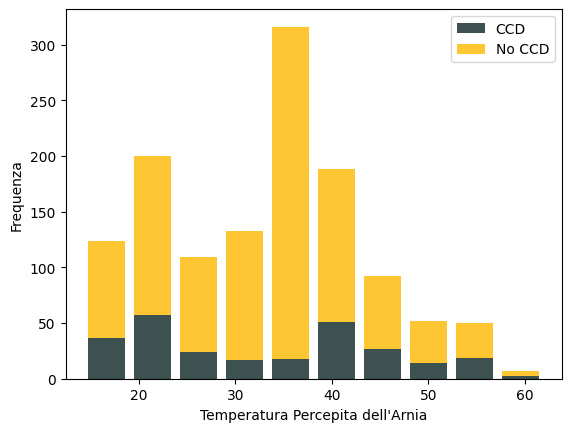

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[dataset["CCD"] == 1]
dataset_ccd_no = dataset[dataset["CCD"] == 0]

# Creazione dell'istogramma
plt.hist([dataset_ccd["apparent hive temp"],dataset_ccd_no["apparent hive temp"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Temperatura Percepita dell'Arnia")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

Come ci aspettavamo, <u>al centro della distribuzione la percentuale dei casi di CCD è minore rispetto agli estremi</u>, dove abbiamo meno misurazioni ma maggior presenza di CCD. Questo è realistico poiché più la temperatura dell'arnia si trova all'interno dell'intervallo prestabilito, maggiori sono le probabilità che le api siano in salute e, di conseguenza, minore è la probabilità che l'arnia sia soggetta al CCD.

Vediamo ora l'istogramma inerente alla differenza tra la temperatura percepita interna ed esterna all'arnia:

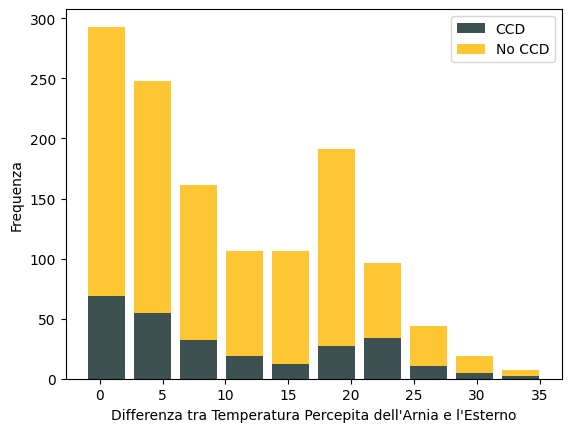

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[dataset["CCD"] == 1]
dataset_ccd_no = dataset[dataset["CCD"] == 0]

# Creazione dell'istogramma
plt.hist([dataset_ccd["apparent temp diff"],dataset_ccd_no["apparent temp diff"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Differenza tra Temperatura Percepita dell'Arnia e l'Esterno")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

Il grafico ci riporta, come sospettavamo, una <u>frequenza maggiore di CCD quando ci avviciniamo allo 0</u>. C'è però da dire che l'euristica ragiona anche in relazione alla temperatura interna (infatti se ci troviamo nel range, la differenza tra interno ed esterno non viene mai considerata).

Vediamo ora l'istogramma di nuovo inerente alla differenza tra la temperatura percepita interna ed esterna all'arnia, ma nel momento in cui la temperatura interna si trova rispettivamente nel range prestabilito e al di fuori del range prestabilito:

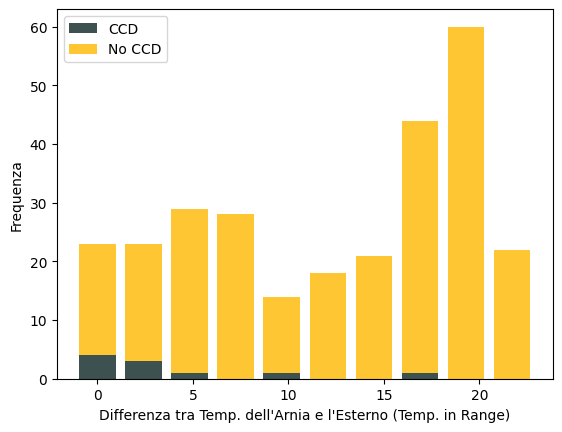

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[(dataset["CCD"] == 1) & (dataset["apparent hive temp"] >= 32) & (dataset["apparent hive temp"] <=37)]
dataset_ccd_no = dataset[(dataset["CCD"] == 0) & (dataset["apparent hive temp"] >= 32) & (dataset["apparent hive temp"] <=37)]

# Crea l'istogramma
plt.hist([dataset_ccd["apparent temp diff"],dataset_ccd_no["apparent temp diff"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Differenza tra Temp. dell'Arnia e l'Esterno (Temp. in Range)")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

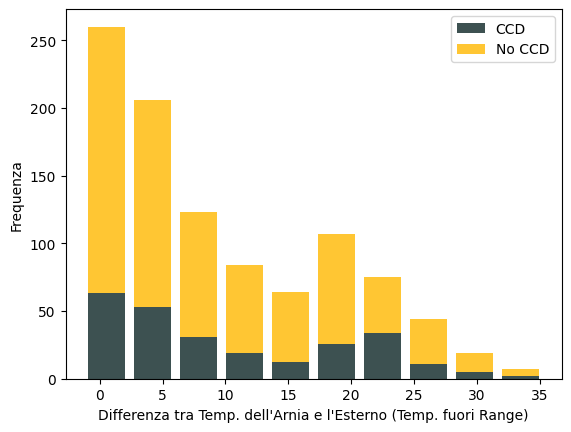

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[(dataset["CCD"] == 1) & ((dataset["apparent hive temp"] < 32) | (dataset["apparent hive temp"] > 37))]
dataset_ccd_no = dataset[(dataset["CCD"] == 0) & ((dataset["apparent hive temp"] < 32) | (dataset["apparent hive temp"] > 37))]

# Crea l'istogramma
plt.hist([dataset_ccd["apparent temp diff"],dataset_ccd_no["apparent temp diff"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Differenza tra Temp. dell'Arnia e l'Esterno (Temp. fuori Range)")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

Come ci aspettavamo, <u>quando la temperatura si trova all'interno del range abbiamo pochi casi di CCD</u>, ovviamente distribuiti maggiormente quando siamo vicini allo 0. Analogamente, <u>quando la temperatura si trova al di fuori del range abbiamo molti più casi di CCD</u>, in particolare quando ci troviamo verso gli estremi della distribuzione. Questo è dovuto probabilmente al fatto che una differenza alta in aggiunta ad una temperatura fuori range causa molto stress alle api, mentre una differenze tendente allo 0 trova spiegazione in quanto detto prima.

Infine, vediamo la frequenza del CCD in relazione alla presenza o all'assenza della regina:

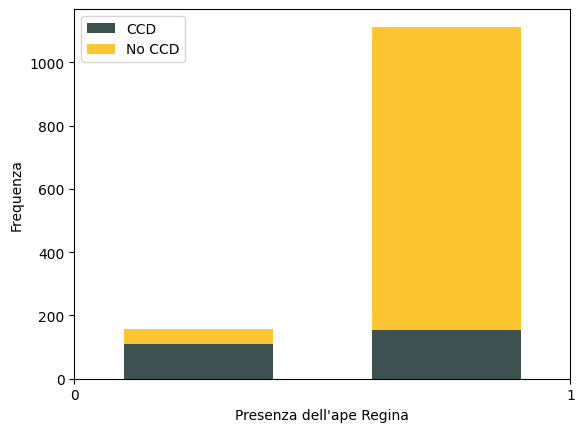

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[dataset["CCD"] == 1]
dataset_ccd_no = dataset[dataset["CCD"] == 0]

# Crea l'istogramma
plt.hist([dataset_ccd["queen presence"],dataset_ccd_no["queen presence"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.6, bins=2)
plt.xticks([0, 1])
plt.xlabel("Presenza dell'ape Regina")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

In linea con le nostre aspettative, <u>quando la regina è assente la frequenza dei casi di CCD è significativamente più alta in proporzione alle misurazioni</u>, difatti questo è il fattore più incidente anche all'interno dell'euristica.

Dunque, da queste considerazioni, possiamo definire la nostra euristica soddisfacente, oltre ad aver già delineato le relazioni tra features e label. Possiamo quindi procedere a **estrarre una parte del dataset, in maniera pseudocasuale, da utilizzare successivamente nella fase di validazione del modello**. Eseguiamo ora tale operazione perché vogliamo che l'algoritmo non veda mai questi dati, così da poterlo testare in maniera corretta. Il numero di righe per ogni label è arbitrario e non è dettato da una particolare euristica o logica.

In [ ]:
demo_dataset_half_1 = dataset.loc[dataset["CCD"] == 1].sample(30)  # Righe in cui vi è il CCD
demo_dataset_half_2 = dataset.loc[dataset["CCD"] == 0].sample(120)  # Righe in cui non vi è il CCD
demo_ds = pd.concat([demo_dataset_half_1, demo_dataset_half_2], axis=0)  # Unione delle due metà del dataset
# La seguente riga è commentata per evitare casualità nelle varie esecuzioni
#demo_ds.to_csv("CCD_demo_dataset.csv", index=False) # RANDOM
demo_ds = pd.read_csv("CCD_demo_dataset.csv")
dataset = dataset.drop(demo_ds.index)  # Eliminazione delle righe estratte dal dataset originale
demo_ds

,queen presence,apparent hive temp,apparent temp diff,CCD
0,0,25.96,7.75,1
1,1,22.55,3.97,1
2,0,20.47,-0.33,1
3,1,37.81,14.78,1
4,1,57.12,23.27,1
...,...,...,...,...
145,1,37.30,19.45,0
146,1,16.64,-0.56,0
147,1,28.63,0.69,0
148,1,38.26,23.07,0


Procediamo con il controllo del bilanciamento della classe da predire:

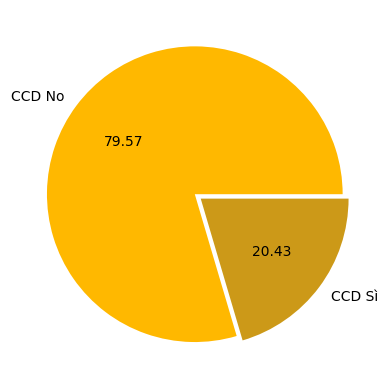

In [ ]:
plt.pie(dataset['CCD'].value_counts(), labels=['CCD No', 'CCD Sì'], colors=["#FFB800","#CC9918"], explode=(0, 0.05), autopct="%0.2f")
plt.show()

In [ ]:
dataset["CCD"].value_counts()

0    892
1    229
Name: CCD, dtype: int64

Come previsto, vi è un **forte sbilanciamento** all'interno del nostro dataset. Per affrontare tale problematica, abbiamo due opzioni:

- Effettuare **esclusivamente un undersampling della classe maggioritaria** sino a raggiungere lo stesso numero delle istanze della classe minoritaria. Questa soluzione è molto semplice, tuttavia applicandola avremmo tra le mani un basso quantitativo di dati;

- Effettuare **sia undersampling della classe maggioritaria che oversampling della classe minoritaria**. In particolare, cercheremmo di ottenere 500 istanze per ognuna delle due classi, così da ottenere un dataset perfettamente bilanciato. Questa soluzione sarebbe ideale, tuttavia ciò rappresenta una sfida di maggiore difficoltà poiché la sua applicazione è più impegnativa e dovremo stare attenti a non perturbare molto la distribuzione dei nostri dati.

Per individuare l'opzione migliore, abbiamo deciso di implementare e testare entrambe.

Applichiamo la <u>**prima soluzione**</u>, effettuando esclusivamente l'undersampling, poiché non c'è molto da ragionare. Il dataset prodotto verrà salvato a parte, così da testarlo analogamente al dataset prodotto applicando la seconda soluzione.

In [ ]:
ccd_dataset_US = dataset.groupby("CCD").apply(lambda x: x.sample(n=min(dataset["CCD"].value_counts()[1], len(x))))
ccd_dataset_US = ccd_dataset_US.reset_index(drop=True)
# La seguente riga è commentata per evitare casualità nelle varie esecuzioni
#ccd_dataset_US.to_csv("CCD_dataset_US.csv", index=False) # RANDOM
ccd_dataset_US = pd.read_csv("CCD_dataset_US.csv")
ccd_dataset_US["CCD"].value_counts()

0    236
1    236
Name: CCD, dtype: int64

Esattamente come abbiamo detto, abbiamo ottenuto lo stesso numero di istanze per ciascuna classe. Tuttavia, come si può notare, i dati non sono molti.

Applichiamo ora la <u>**seconda soluzione**</u>, che non risulta essere semplice come la prima, cominciando dall'oversampling. Poiché il quantitativo di dati in merito all'argomento è molto limitato, abbiamo deciso di optare per la tecnica di ***Data Synthesis***, ovvero il processo di generazione di dati artificiali, quindi non direttamente provenienti da una raccolta di dati del mondo reale. In particolare, genereremo nuovi campioni artificiali basandoci su quelli già esistenti all'interno del nostro dataset. Riguardo a ciò, abbiamo diligentemente preservato un livello di realismo nelle nuove istanze generate, introducendo delle variazioni pseudo-casuali e controllate. Per farlo, abbiamo stabilito dei template per generare dei valori realistici e basati sulle misurazioni e proporzioni sviluppate e osservate precedentemente:

- **Presenza della regina**: osservando la frequenza del CCD in relazione alla presenza o all'assenza della regina, i campioni la cui label del CCD è "True" presentano una regina assente nell'80% dei casi. Per questo motivo, i nuovi campioni generati avranno la colonna relativa alla presenza della regina di valore pari a 0 con una probabilità dell'80%;

- **Temperatura percepita interna all'arnia**: innanzitutto, dobbiamo stabilire le probabilità in cui la temperatura percepita della nuova istanza generata cada al di fuori oppure all'interno del range prestabilito. Poiché è ovviamente più grave che la temperatura si trovi fuori dal range, la probabilità di generare una temperatura sballata sarà più alta. Successivamente, per quanto riguarda i valori da generare effettivi, al corrispettivo estremo del range superato aggiungeremo o sottrarremo rispettivamente un numero decimale da 0 a 15. Avremmo potuto andare oltre allargando questo intervallo di valori, e da un certo punto di vista sarebbe stato vantaggioso, poiché più ci allontaniamo dal range ottimale e maggiore è la possibilità di ottenere un'istanza con CCD positivo. Tuttavia, un intervallo più grande potrebbe generare numeri troppo vicini agli estremi, quindi più lontani dalle istanze che popolano la maggior parte del dataset. In altri termini, non avremmo ottenuto risultati realistici e conformi a ciò che è stato stabilito in precedenza;

- **Differenza tra temperatura percepita esterna e interna all'arnia**: questo valore può cambiare in base al valore della temperatura percepita interna all'arnia che abbiamo ottenuto. In particolare, se la temperatura generata si trova nel range ottimale prestabilito, questo valore oscillerà tra 0 e 1 oppure tra 2 e 25. La probabilità che il valore generato rientri nel primo intervallo sarà più alta rispetto al secondo. Altrimenti, se la temperatura generata è fuori dal range, questo valore potrà assumere un valore tra 0 e 10, 11 e 20 oppure 21 e 25. La probabilità che il valore rientri nel primo, secondo o terzo intervallo segue esattamente l'ordine in cui sono stati dichiarati (P(0-10) > P(11-20) > P(21-25)). Questo perché, come abbiamo già definito, più la differenza di temperatura è vicina allo zero e maggiore sarà il rischio di CCD. Questi intervalli sono stati stabiliti seguendo lo stesso ragionamento sviluppato al passo precedente.

Dopo aver generato i tre valori di un'istanza, riapplicheremo l'euristica per ottenerne la relativa label, così da preservare:

In [ ]:
# Definizione del numero di righe del dataset in cui il CCD ha valore 1
CCD_rows = dataset["CCD"].value_counts()[1]

while CCD_rows < 500:

    # Calcolo della presenza dell'ape regina
    if random.random() >= 0.80:
        queen_mock = 0
    else:
        queen_mock = 1

    # Calcolo della temperatura percepita
    if random.random() >= 0.60:  # Probabilità del 40% che la temperatura sia al di sopra del range
        temp_mock = 37 + random.randint(0, 15) + round(random.random(), 2)  # Valore al di sopra del range da 0 a 15
    elif random.random() <= 0.40:  # Probabilità del 40% che la temperatura sia al di sotto del range
        temp_mock = 32 - random.randint(0, 15) - round(random.random(), 2)  # Valore al di sotto del range da 0 a 15
    else:  # Probabilità del 20% che la temperatura sia all'interno del range
        temp_mock = random.randint(32, 37) + round(random.random(), 2)  # Valore all'interno del range da 32 a 36

    # Inutile continuare poiché valori del genere genererebbero una probabilità di CCD pari a 0
    if 32 <= temp_mock <= 37 and queen_mock == 1:
        continue

    # Calcolo della differenza tra temperatura interna ed esterna
    if 32 <= temp_mock <= 37:  # Se la temperatura generata è in range...
        if random.random() >= 0.30:  # Probabilità del 70% che la differenza di temperatura sia tra 0 e 1
            temp_diff_mock = random.randint(0, 1) + round(random.random(), 2)
        else:  # Probabilità del 30% che la differenza di temperatura sia tra 2 e 25
            temp_diff_mock = random.randint(2, 25) + round(random.random(), 2)
    else:  # Se la temperatura generata è fuori range...
        if random.random() >= 0.40:  # Probabilità del 60% che la differenza di temperatura sia tra 0 e 10
            temp_diff_mock = random.randint(0, 10) + round(random.random(), 2)
        elif random.random() <= 0.10:  # Probabilità del 10% che la differenza di temperatura sia tra 21 e 25
            temp_diff_mock = random.randint(21, 25) + round(random.random(), 2)
        else:  # Probabilità del 30% che la differenza di temperatura sia tra 11 e 20
            temp_diff_mock = random.randint(11, 20) + round(random.random(), 2)

    # Creazione di un dizionario con 3 chiavi associate ai 3 valori calcolati in precedenza
    row = {"queen presence": [queen_mock], "apparent hive temp": [temp_mock], "apparent temp diff": [temp_diff_mock]}
    # Conversione del dizionario in un DataFrame
    row = pd.DataFrame.from_dict(row)

    # Applicazione della nostra euristica
    AristeoHeuristic(row)

    # Concatenazione dei DataFrame per ottenere il dataset di campioni con CDD = True
    if int(row["CCD"]) == 1:
        dataset = pd.concat([dataset, row], axis=0)
        CCD_rows+=1

dataset

,queen presence,apparent hive temp,apparent temp diff,CCD
150,1,18.49,3.79,0
151,1,18.81,4.86,0
152,1,18.66,5.07,0
153,1,18.04,4.71,0
154,1,17.61,4.43,0
...,...,...,...,...
0,0,39.96,0.79,1
0,0,37.60,0.92,1
0,1,47.80,14.68,1
0,0,39.92,19.35,1


Per verificare la correttezza dell'oversampling applicato, visualizziamo nuovamente i grafici inerenti ad ognuna delle tre features per controllare che le distribuzioni siano rimaste simili alle precedenti:

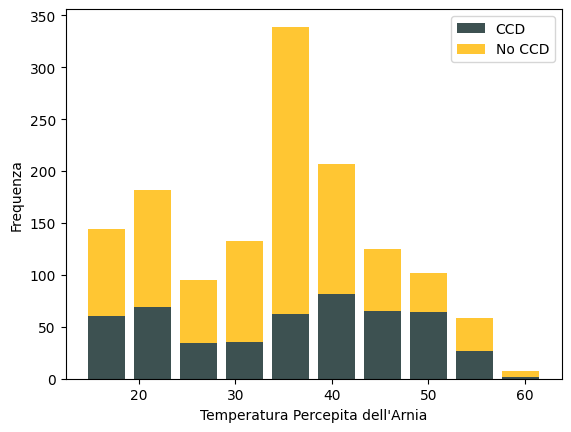

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[dataset["CCD"] == 1]
dataset_ccd_no = dataset[dataset["CCD"] == 0]

# Creazione dell'istogramma
plt.hist([dataset_ccd["apparent hive temp"],dataset_ccd_no["apparent hive temp"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Temperatura Percepita dell'Arnia")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

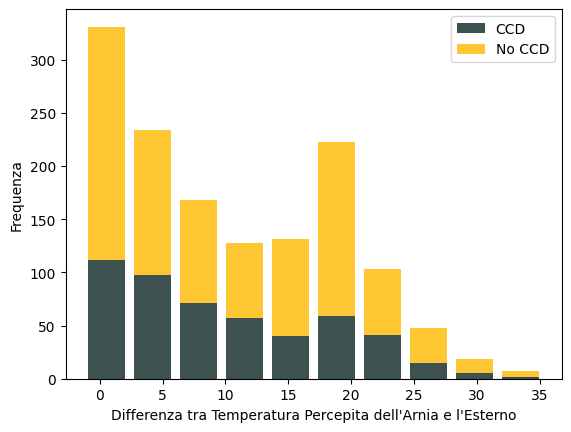

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[dataset["CCD"] == 1]
dataset_ccd_no = dataset[dataset["CCD"] == 0]

# Creazione dell'istogramma
plt.hist([dataset_ccd["apparent temp diff"],dataset_ccd_no["apparent temp diff"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Differenza tra Temperatura Percepita dell'Arnia e l'Esterno")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

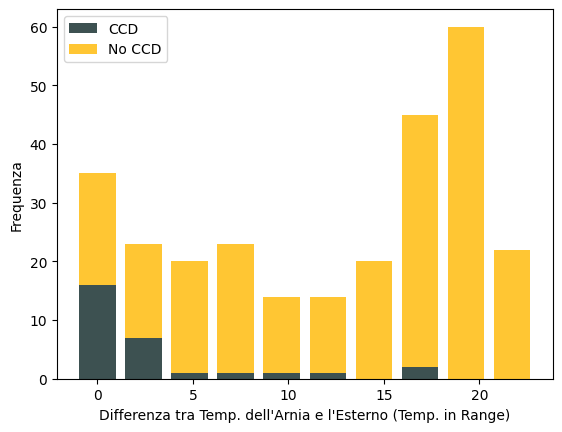

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[(dataset["CCD"] == 1) & (dataset["apparent hive temp"] >= 32) & (dataset["apparent hive temp"] <=37)]
dataset_ccd_no = dataset[(dataset["CCD"] == 0) & (dataset["apparent hive temp"] >= 32) & (dataset["apparent hive temp"] <=37)]

# Creazione dell'istogramma
plt.hist([dataset_ccd["apparent temp diff"],dataset_ccd_no["apparent temp diff"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Differenza tra Temp. dell'Arnia e l'Esterno (Temp. in Range)")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

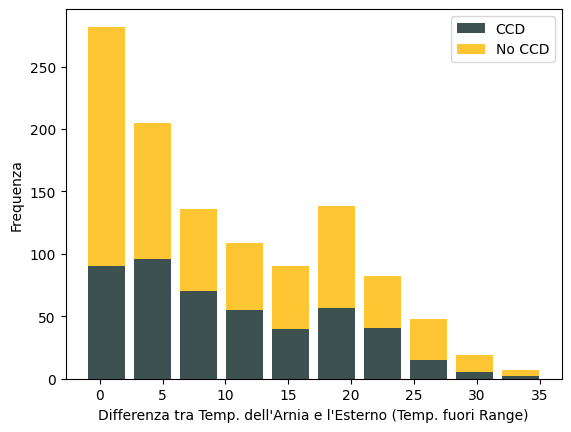

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[(dataset["CCD"] == 1) & ((dataset["apparent hive temp"] < 32) | (dataset["apparent hive temp"] > 37))]
dataset_ccd_no = dataset[(dataset["CCD"] == 0) & ((dataset["apparent hive temp"] < 32) | (dataset["apparent hive temp"] > 37))]

# Creazione dell'istogramma
plt.hist([dataset_ccd["apparent temp diff"],dataset_ccd_no["apparent temp diff"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.8)

plt.xlabel("Differenza tra Temp. dell'Arnia e l'Esterno (Temp. fuori Range)")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

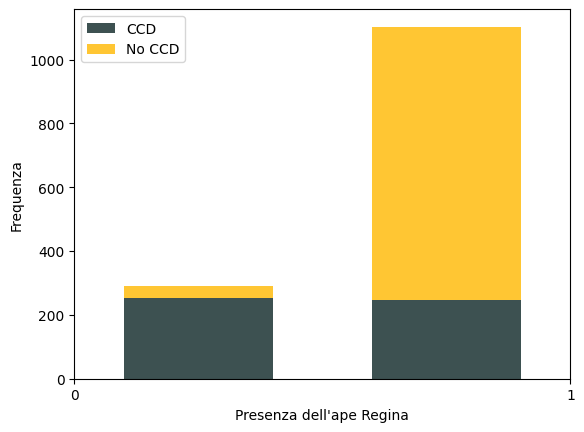

In [ ]:
# Creazione di due dataframe (uno i cui dati hanno label CDD true, l'altro false)
dataset_ccd = dataset[dataset["CCD"] == 1]
dataset_ccd_no = dataset[dataset["CCD"] == 0]

# Creazione dell'istogramma
plt.hist([dataset_ccd["queen presence"],dataset_ccd_no["queen presence"]], color=["#0C2626","#FFB800"], alpha=0.8, stacked=True, rwidth=0.6, bins=2)

plt.xticks([0, 1])
plt.xlabel("Presenza dell'ape Regina")
plt.ylabel("Frequenza")
plt.legend(["CCD", "No CCD"])

plt.show()

In [ ]:
dataset["CCD"].value_counts()

0    892
1    500
Name: CCD, dtype: int64

Possiamo vedere come la distribuzione della label del CCD, seppur di poco, non è cambiata notevolmente. Possiamo quindi ritenerci soddisfatti dei risultati ottenuti, poiché realistici e conformi al dataset di partenza.

Concludiamo con l'undersampling della classe maggioritaria:

In [ ]:
ccd_dataset_OS = dataset.groupby("CCD").apply(lambda x: x.sample(n=min(500, len(x))))
ccd_dataset_OS = ccd_dataset_OS.reset_index(drop=True)
# La seguente riga è commentata per evitare discrepanze tra i risultati
#ccd_dataset_OS.to_csv("CCD_dataset_OS.csv", index=False)  # RANDOM
ccd_dataset_OS = pd.read_csv("CCD_dataset_OS.csv")
ccd_dataset_OS["CCD"].value_counts()

0    500
1    500
Name: CCD, dtype: int64

Andiamo ora a convertire i dati in un formato che sia leggibile ai modelli che andremo ad addestrare e testare:

In [ ]:
X_train_US = ccd_dataset_US[["queen presence", "apparent hive temp", "apparent temp diff"]].to_numpy()
y_train_US = ccd_dataset_US[["CCD"]].to_numpy()
X_train_OS = ccd_dataset_OS[["queen presence", "apparent hive temp", "apparent temp diff"]].to_numpy()
y_train_OS = ccd_dataset_OS["CCD"].to_numpy()

Eseguite queste ultime operazioni, i dati sono pronti per il training e si può passare alla prossima fase.

# Data Modeling

Durante la fase di training utilizziamo una ***stratified k-fold validation*** con k = 10 per diagnosticare eventuali problemi di overfitting e le performance generali dei modelli e la applicheremo sui quattro modelli di classificazione che abbiamo deciso di utilizzare e testare: ***Decision Tree***, ***Random Forest***, ***Naive Bayes*** e ***K-Nearest Neighbors***.

Per ognuno di questi algoritmi, calcoleremo le metriche di valutazione e le medie relative ad esse. In particolare, le metriche che utilizzeremo sono le seguenti: ***Accuracy***, ***Precision***, ***Recall*** e ***F1 Score***.

Cominciamo **definendo ognuno dei classificatori** da utilizzare:

In [ ]:
models = {}  #  Dictionary contenente i diversi classificatori

# Decision Tree
models['Decision Tree'] = DecisionTreeClassifier()

# Random Forest
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
models['K-Nearest Neighbor'] = KNeighborsClassifier()

Testiamo ogni modello con il **training set generato dall'applicazione dell'undersampling, senza oversampling**:

In [ ]:
skf = StratifiedKFold(n_splits = 10)  #  Applicazione della Stratified K-Fold Validation (k=10)
accuracy, precision, recall, f1 = {}, {}, {}, {}  # Dictionary relativi alle metriche di valutazione

# Definiamo delle liste per salvare le metriche
for key in models.keys():
    accuracy[key] = []
    precision[key] = []
    recall[key] = []
    f1[key] = []

for train, test in skf.split(X_train_US, y_train_US):
    for key in models.keys():

        # Addestramento del modello
        models[key].fit(X_train_US[train], y_train_US[train].ravel())

        # Predizioni
        predictions = models[key].predict(X_train_US[test])

        # Calcolo delle metriche
        accuracy[key].append(accuracy_score(y_true = y_train_US[test], y_pred = predictions))
        precision[key].append(precision_score(y_true = y_train_US[test], y_pred = predictions))
        recall[key].append(recall_score(y_true = y_train_US[test], y_pred = predictions))
        f1[key].append(f1_score(y_true = y_train_US[test], y_pred = predictions))

mean_accuracy_US = []
mean_precision_US = []
mean_recall_US = []
mean_f1_US = []

# Calcolo delle medie delle metriche di valutazione
for key in models.keys():
    mean_accuracy_US.append(round(np.mean(accuracy[key]),4))
    mean_precision_US.append(round(np.mean(precision[key]),4))
    mean_recall_US.append(round(np.mean(recall[key]),4))
    mean_f1_US.append(round(np.mean(f1[key]),4))

Facciamo lo stesso, ma questa volta con il **training set generato dall'applicazione dell'undersampling e dell'oversampling**:

In [ ]:
# Applicazione della Stratified K-Fold Validation (k=10)
skf = StratifiedKFold(n_splits = 10)
accuracy, precision, recall, f1 = {}, {}, {}, {}

# Definiamo delle liste per salvare le metriche
for key in models.keys():
    accuracy[key] = []
    precision[key] = []
    recall[key] = []
    f1[key] = []

for train, test in skf.split(X_train_OS, y_train_OS):
    for key in models.keys():

        # Addestramento del modello
        models[key].fit(X_train_OS[train], y_train_OS[train])

        # Predizioni
        predictions = models[key].predict(X_train_OS[test])

        # Calcolo delle metriche
        accuracy[key].append(accuracy_score(y_true = y_train_OS[test], y_pred = predictions))
        precision[key].append(precision_score(y_true = y_train_OS[test], y_pred = predictions))
        recall[key].append(recall_score(y_true = y_train_OS[test], y_pred = predictions))
        f1[key].append(f1_score(y_true = y_train_OS[test], y_pred = predictions))

mean_accuracy_OS = []
mean_precision_OS = []
mean_recall_OS = []
mean_f1_OS = []

# Calcolo delle medie delle metriche di valutazione
for key in models.keys():
    mean_accuracy_OS.append(round(np.mean(accuracy[key]),4))
    mean_precision_OS.append(round(np.mean(precision[key]),4))
    mean_recall_OS.append(round(np.mean(recall[key]),4))
    mean_f1_OS.append(round(np.mean(f1[key]),4))

Adesso, analizziamo una per una le metriche ottenute, così da capire **quale delle due opzioni applicate si è dimostrata più efficace**:

In [ ]:
# Visualizzazione delle medie calcolate precedentemente
scores = pd.DataFrame(index=models.keys(), columns=["Accuracy US", "Accuracy OS", "Precision US", "Precision OS", "Recall US", "Recall OS", "F1 Score US", "F1 Score OS"])
scores["Accuracy US"] = mean_accuracy_US  # Media delle Accuracy ottenute con undersampling
scores["Accuracy OS"] = mean_accuracy_OS  # Media delle Accuracy ottenute con undersampling e oversampling
scores["Precision US"] = mean_precision_US  # Media delle Precision ottenute con undersampling
scores["Precision OS"] = mean_precision_OS  # Media delle Precision ottenute con undersampling e oversampling
scores["Recall US"] = mean_recall_US  # Media delle Recall ottenute con undersampling
scores["Recall OS"] = mean_recall_OS  # Media delle Recall ottenute con undersampling e oversampling
scores["F1 Score US"] = mean_f1_US  # Media degli F1 Score ottenuti con undersampling
scores["F1 Score OS"] = mean_f1_OS  # Media degli F1 Score ottenuti con undersampling e oversampling

scores

,Accuracy US,Accuracy OS,Precision US,Precision OS,Recall US,Recall OS,F1 Score US,F1 Score OS
Decision Tree,0.6629,0.703,0.6701,0.7050,0.6609,0.704,0.6625,0.7034
Random Forest,0.6863,0.739,0.6916,0.7540,0.6832,0.714,0.6850,0.7322
Naive Bayes,0.7140,0.729,0.9197,0.9139,0.4759,0.508,0.6175,0.6514
K-Nearest Neighbor,0.6015,0.676,0.6036,0.7035,0.5819,0.616,0.5911,0.6544


Dai risultati ottenuti, si evince che lavorare con <u>**il dataset ottenuto dall'applicazione dell'oversampling insieme all'undersampling produce risultati migliori**</u>. Ne consegue che, d'ora in poi, procederemo con l'addestramento utilizzando esclusivamente tale dataset:

In [ ]:
X_train = X_train_OS
y_train = y_train_OS

Oltre a ciò, osservando nuovamente i risultati ottenuti, risulta evidente che il classificatore che presenta le <u>migliori prestazioni</u>, facendo particolare attenzione alla Recall dati i notevoli impatti che i falsi negativi hanno sul nostro modello, è il **Random Forest**, che risulta leggermente migliore rispetto al Decision Tree. Tuttavia, anche **Naive Bayes** non è da sottovalutare, poiché pur avendo una Recall più bassa presenta una Precision di gran lunga superiore. Vale la pena, quindi, osservare entrambi. Vediamo se riusciamo ad ottimizzare le prestazioni di questi due modelli ricorrendo al *model tuning*.

Partiamo dal Random Forest, utilizzando la ***Grid Search*** per trovare la miglior configurazione di parametri per il nostro problema e produrre un nuovo modello da testare:

In [ ]:
rf = RandomForestClassifier()

n_estimators = [1,3,5,7,9,11,13] # Numero di alberi
max_depth = [10,20,30,40,50,60,70,80,90,100] # Profondità massima
min_samples_split = [2, 6, 10] #Numero minimo di sample per effettuare uno split
min_samples_leaf = [1, 3, 5] #Numero minimo di sample per generare una foglia
bootstrap = [True, False]

rf_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

# Invochiamo la Grid Search per trovare i parametri ottimi
random_forest = GridSearchCV(estimator = rf, param_grid = rf_grid, scoring="accuracy", n_jobs=8, cv=5, verbose=2, refit="True")
# Una volta trovati trainiamo il modello sul nostro training set
random_forest.fit(X_train, y_train)

best_config_rf = random_forest.best_params_
print(f"Configurazione ottimale: {best_config_rf}")

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits
Configurazione ottimale: {'bootstrap': True, 'max_depth': 50, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 13}


Facciamo lo stesso per Naive Bayes:

In [ ]:
gNB = GaussianNB()

nb_grid = {
    "var_smoothing": np.logspace(0, -9, num=100)
}

# Invochiamo la Grid Search per trovare i parametri ottimi
naive_bayes = GridSearchCV(estimator = gNB, param_grid = nb_grid, scoring="accuracy", n_jobs=8, cv=5, verbose=2, refit="True")
# Una volta trovati trainiamo il modello sul nostro training set
naive_bayes.fit(X_train, y_train)

best_config_nb = naive_bayes.best_params_
print(f"Configurazione ottimale: {best_config_nb}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Configurazione ottimale: {'var_smoothing': 0.004328761281083057}


# Evaluation

Prima di tutto, per effettuare la validazione del modello, recuperiamo il **dataset contenente le righe estratte** precedentemente dal dataset originale:

In [ ]:
# Disabilitiamo la visualizzazione delle tabelle di Colab per questioni di performance
data_table.disable_dataframe_formatter()
ccd_demo_dataset = pd.read_csv("CCD_demo_dataset.csv")
ccd_demo_dataset

,queen presence,apparent hive temp,apparent temp diff,CCD
0,0,25.96,7.75,1
1,1,22.55,3.97,1
2,0,20.47,-0.33,1
3,1,37.81,14.78,1
4,1,57.12,23.27,1
...,...,...,...,...
145,1,37.30,19.45,0
146,1,16.64,-0.56,0
147,1,28.63,0.69,0
148,1,38.26,23.07,0


Successivamente, come fatto in precedenza, trasformiamo i nostri dati in un formato accettabile dai nostri modelli, ovvero **array NumPy**:

In [ ]:
# Convertiamo i dati in un formato leggibile al modello
X_test = ccd_demo_dataset[["queen presence", "apparent hive temp", "apparent temp diff"]].to_numpy()
y_test = ccd_demo_dataset["CCD"].to_numpy()

Adesso, osserviamo come si comporta il Random Forest ottimizzato, visualizzando prima di tutto le **metriche**:

In [ ]:
# Utilizzo del modello
prediction = random_forest.predict(X_test)

# Valutazione del modello in base alle metriche
accuracy_val_rf = accuracy_score(y_true = y_test, y_pred = prediction)
precision_val_rf = precision_score(y_true = y_test, y_pred = prediction)
recall_val_rf = recall_score(y_true = y_test, y_pred = prediction)
f1_val_rf = f1_score(y_true = y_test, y_pred = prediction)

print(f"Random Forest Accuracy: {accuracy_val_rf*100:.4f}%, Precision: {precision_val_rf*100:.4f}%, Recall: {recall_val_rf*100:.4f}%, F1 Score: {f1_val_rf*100:.4f}%")

Random Forest Accuracy: 76.0000%, Precision: 42.8571%, Recall: 60.0000%, F1 Score: 50.0000%


Successivamente, osserviamo la ***confusion matrix***:

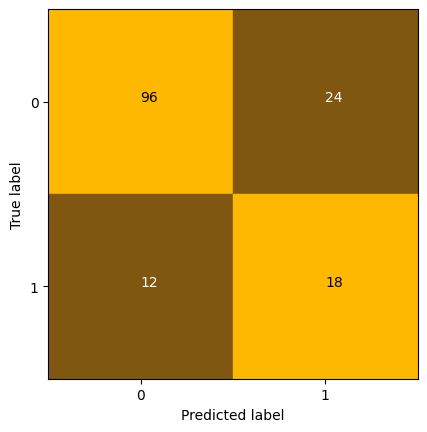

In [ ]:
# Creazione della matrice di confusione
matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Definizione dei colori da utilizzare nella matrice con relativa color map e color matrix
colors=['#FFB800', '#CC9918']
color_map = ListedColormap('white', name='colormap_list')
color_matrix = [['#FFB800', '#805711'], ['#805711', '#FFB800']]
color_text_matrix = [['black', 'white'], ['white', 'black']]

# Visualizzazione della matrice di confusione
plt.imshow(matrix, cmap=color_map, origin='upper')

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        # Definizione dei dettagli in merito a colore e testo per le celle della matrice
        plt.text(j, i, str(matrix[i, j]), color=color_text_matrix[i][j])
        plt.fill_between([j-0.5, j+0.5], i-0.5, i+0.5, color=color_matrix[i][j], alpha=1)

# Set dei valori e delle labels presenti su asse x e asse y
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

Infine, osserviamo la ***ROC Curve***:

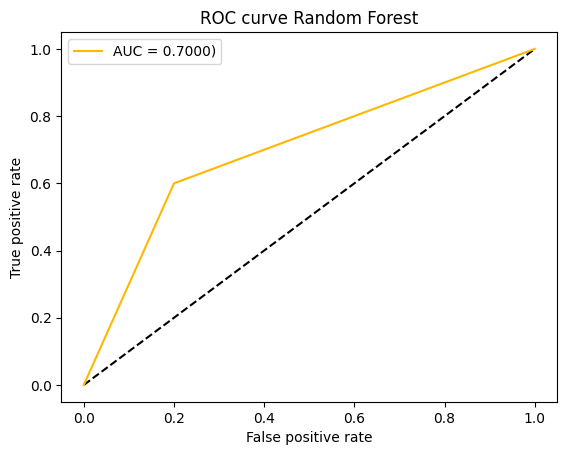

In [ ]:
# Calcolo del tasso di falsi positivi, veri positivi e le soglie
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, prediction)
# Disegno della linea di riferimento
plt.plot([0, 1], [0, 1], 'k--')
# Disegno della ROC Curve, etichettandola con il valore dell'AUC (più vicino è a 1, migliore è il modello)
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f})'.format(auc(false_positive_rate, true_positive_rate)), color="#FFB800")

# Definizione del titolo e delle labels
plt.title('ROC curve Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

plt.show()

Osserviamo che <u>le prestazioni non sono pessime, ma tendenzialmente la Recall non raggiunge risultati particolarmente soddisfacenti</u>.

Passiamo ora a valutare Naive Bayes ottimizzato, visualizzando prima di tutto le **metriche**:

In [ ]:
# Utilizzo del modello
prediction = naive_bayes.predict(X_test)

# Valutazione del modello in base alle metriche
accuracy_val_nb = accuracy_score(y_true = y_test, y_pred = prediction)
precision_val_nb = precision_score(y_true = y_test, y_pred = prediction)
recall_val_nb = recall_score(y_true = y_test, y_pred = prediction)
f1_val_nb = f1_score(y_true = y_test, y_pred = prediction)

print(f"Naive Bayes Accuracy: {accuracy_val_nb*100:.4f}%, Precision: {precision_val_nb*100:.4f}%, Recall: {recall_val_nb*100:.4f}%, F1 Score: {f1_val_nb*100:.4f}%")

Naive Bayes Accuracy: 83.3333%, Precision: 60.0000%, Recall: 50.0000%, F1 Score: 54.5455%


Successivamente, osserviamo la ***confusion matrix***:

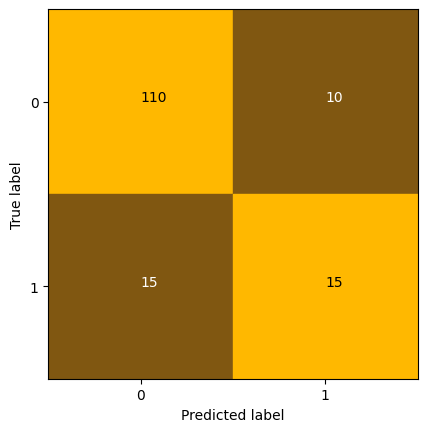

In [ ]:
# Creazione della matrice di confusione
matrix = confusion_matrix(y_true = y_test, y_pred = prediction)

# Definizione dei colori da utilizzare nella matrice con relativa color map e color matrix
colors=['#FFB800', '#805711']
color_map = ListedColormap('white', name='colormap_list')
color_matrix = [['#FFB800', '#805711'], ['#805711', '#FFB800']]
color_text_matrix = [['black', 'white'], ['white', 'black']]

# Visualizzazione della matrice di confusione
plt.imshow(matrix, cmap=color_map, origin='upper')

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        # Definizione dei dettagli in merito a colore e testo per le celle della matrice
        plt.text(j, i, str(matrix[i, j]), color=color_text_matrix[i][j])
        plt.fill_between([j-0.5, j+0.5], i-0.5, i+0.5, color=color_matrix[i][j], alpha=1)

# Set dei valori e delle labels presenti su asse x e asse y
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

Infine, osserviamo la ***ROC Curve***:

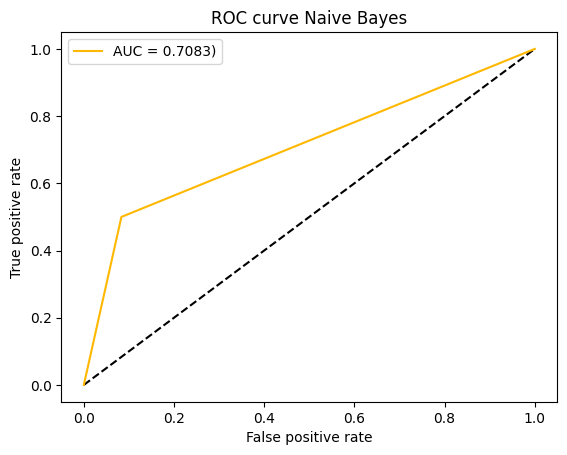

In [ ]:
# Calcolo del tasso di falsi positivi, veri positivi e le soglie
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, prediction)
# Disegno della linea di riferimento
plt.plot([0, 1], [0, 1], 'k--')
# Disegno della ROC Curve, etichettandola con il valore dell'AUC (più vicino è a 1, migliore è il modello)
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.4f})'.format(auc(false_positive_rate, true_positive_rate)), color="#FFB800")

# Definizione del titolo e delle labels
plt.title('ROC curve Naive Bayes')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

plt.show()

Osserviamo che le prestazioni sono <u>tendenzialmente migliori da tutti i fronti, ad eccezione della Recall</u>, dove abbiamo prestazioni inferiori a Random Forest.

Ora, per comprendere al meglio la differenza che c'è tra i due modelli, **visualizziamo le metriche di entrambi i classificatori su un plot**, così da osservare graficamente i diversi risultati ottenuti da ogni modello:

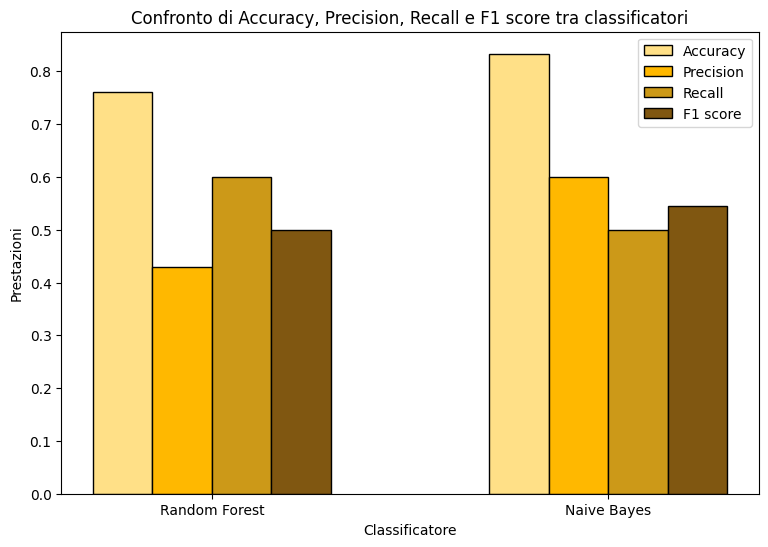

In [ ]:
algorithms = ['Random Forest', 'Naive Bayes']

# Risultati delle prestazioni racchiusi in una lista (una per metrica)
accuracy_results = [accuracy_val_rf, accuracy_val_nb]
precision_results = [precision_val_rf, precision_val_nb]
recall_results = [recall_val_rf, recall_val_nb]
f1_results = [f1_val_rf, f1_val_nb]

# Posizioni delle barre
index = np.arange(len(algorithms))
# Larghezza delle barre
bar_width = 0.15

# Dimensioni della figura
plt.figure(figsize=(9, 6))
# Barre relative a Accuracy, Precision, Recall e F1 Score
accuracy_bar = plt.bar(index, accuracy_results, bar_width, label='Accuracy', color='#FFE087', edgecolor='black')
precision_bar = plt.bar(index + bar_width, precision_results, bar_width, label='Precision', color='#FFB800', edgecolor='black')
recall_bar = plt.bar(index + 2 * bar_width, recall_results, bar_width, label='Recall', color='#CC9918', edgecolor='black')
f1_bar = plt.bar(index + 3 * bar_width, f1_results, bar_width, label='F1 score', color='#805711', edgecolor='black')

# Dettagli del grafico
plt.xlabel('Classificatore')
plt.ylabel('Prestazioni')
plt.title("Confronto di Accuracy, Precision, Recall e F1 score tra classificatori")
plt.xticks(index + 1.5 * bar_width, algorithms)
plt.legend()

plt.show()

Da questo grafico possiamo trarre le nostre considerazioni:

- Random Forest presenta dei <u>risultati mediamente peggiori, tuttavia ha una Recall più alta</u>, che è di particolare interesse al nostro problema;

- Naive Bayes presenta dei <u>risultati mediamente migliori, tuttavia ha una Recall significativamente inferiore</u>;

Dopo un'attenta analisi, basata anche sull'usabilità del modello, <u>**si è deciso di procedere con Naive Bayes**</u>. Questo perché abbiamo ritenuto opportuno prendere un modello che mediamente effettua meno predizioni errate, poiché risulterebbe stressante per un apicoltore trovarsi di fronte ad un gran numero di falsi allarmi, e la percentuale di Recall persa non è così significativa da andare a discriminare completamente questa scelta.

Detto questo procediamo a salvare il modello così da passare alla fase di Deployment

In [ ]:
# Il seguente codice è commentato per evitare casualità nelle varie esecuzioni.
# Il modello sarà da noi fornito all'interno della repo sotto src/ai/development/ML
# f = open("Naive_Bayes.pickle", "wb") # RANDOM
# pickle.dump(naive_bayes, f)
# f.close()

Arrivati a questo punto, vi sono delle ultime considerazioni da fare sul nostro modello. Seppur le prestazioni non sono ottimali, e in generale il modello risultante è sub-ottimo per definizione (stiamo escludendo il peso dell'arnia, di cui non avevamo il dato, e il labeling è basato su un'euristica da noi definita) possiamo riternerci molto soddisfatti del lavoro svolto. Abbiamo avuto modo di applicare numerose tecniche, che si sono rivelate utili nell'ottenere, anche se di poco, un modello migliore. In particolare, abbiamo avuto la possibilità di adottare tecniche come la Data Synthesis, basata su nostre intuizioni, osservazioni e studi, rivelatesi poi corrette, insieme al Fine Tuning con Grid Search. Volendo migliorare il lavoro svolto, sicuramente sarebbe necessario avere un dataset etichettato da degli esperti e non da un'euristica, oltre ad avere a disposizione la colonna relativa al peso dell'arnia, entrambe cose che sono purtroppo fuori dal nostro controllo (difatti il problema del CCD, seppur ben documentato nella letteratura scientifica, manca di dataset affidabili su cui lavorare).

# Deployment

Finalmente, il nostro modello è pronto per essere messo in funzione. Per il Deploy si è optato anche qui di utilizzare Flask, così da permetterci di interagire con il sistema attraverso il protocollo HTTP, per poter poi importare il tutto anche in altri sistemi software. È bene notare inoltre che qui stiamo rilasciando il modello senza integrare la CNN. Tale integrazione verrà effettuata in un altro script.

In [ ]:
# Inizializziamo Flask
app = Flask(__name__)
# Carichiamo il modello prima di Flask così da ridurre il tempo di computazione una volta attivato il server
f = open("Naive_Bayes.pickle", "rb")
model = pickle.load(f)
f.close()

# Ascoltiamo sull'url http://127.0.0.1:5000/predict_ccd_fia per permetterci di comunicare attraverso HTTP
@app.route("/predict_ccd_fia",methods=["POST"])
def predict_CCD():
    if request.method == "POST":
        # Prendiamo i dati inviati attraverso HTTP
        decoded_data = request.data.decode("utf-8")
        input_json = json.loads(decoded_data)

        # In ordine abbiamo queen presence, apparent hive temp, apparent temp diff
        to_predict = np.fromiter(input_json.values(), dtype=float)

        # Formattiamo l'input in un formato leggibile al nostro modello
        list = []
        list.append(to_predict)
        predict_array = np.asarray(list)

        # Effettuiamo la previsione
        prediction = model.predict(predict_array)
        prediction = prediction.flatten()
        prediction = np.where(prediction > 0.5, 1, 0)

        # Restituiamo la previsione
        return jsonify ({"ccd_result": int(prediction[0])})

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
